# ***Dataset Collection***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil

os.environ['KAGGLE_USERNAME'] = "user_name"
os.environ['KAGGLE_KEY'] = "API_KEY"

In [ ]:
!kaggle datasets download -d arjuntejaswi/plant-village

plant-village.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
if not os.path.exists("drive/MyDrive/Datasets/PlantVillage"):
  from zipfile import ZipFile

  with ZipFile('/content/plant-village.zip', 'r') as zip:
    zip.extractall()
    print("Done!")

  files = os.listdir("PlantVillage")

  for file_name in files:
    if "Tomato" in file_name and ".JPG" not in file_name:
      shutil.move(os.path.join("PlantVillage/"+file_name), "drive/MyDrive/Datasets/PlantVillage")

  files = os.listdir("drive/MyDrive/Datasets/PlantVillage")

# ***Importing Libraries for Models***

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Defining Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
FILE_PATH = "/content/drive/MyDrive/Datasets/PlantVillage/"

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = FILE_PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 8837 files belonging to 9 classes.


In [ ]:
class_names = dataset.class_names

In [ ]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus']

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 7 7 5 7 5 7 3 7 7 7 3 8 5 7 3 7 7 2 3 2 8 3 7 7 7 3 7 7 2 2 5]


From the output of cell, we can see that in one batch we have 32 images with image size 256 x 256 and each image has three channel i.e., RGB

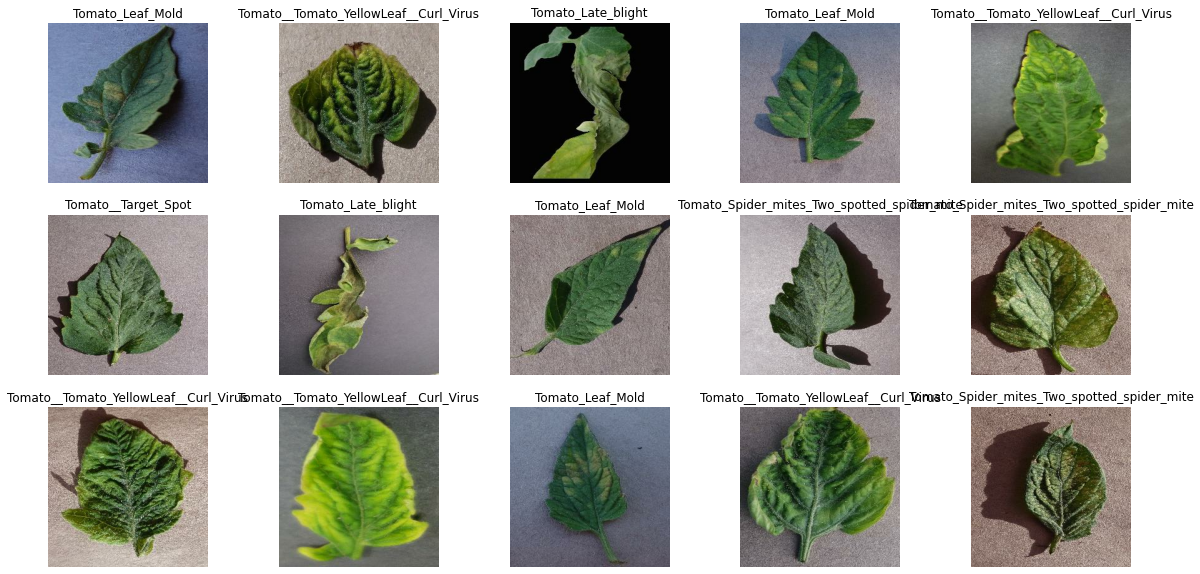

In [ ]:
plt.figure(figsize = (20,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

# ***Train-Test Split***

In [ ]:
def dataset_split(dataset, train_split = 0.7, test_split = 0.2, val_split = 0.1, shuffle = True, shuffle_size = 10000):
  # assert  train_split+test_split+val_split == 1
  dataset_size = len(dataset)
  if shuffle:
    dataset.shuffle(shuffle_size, seed = 10)
  
  train_size = int(len(dataset) * train_split)
  test_size = int(len(dataset) * test_split)
  
  train_data = dataset.take(train_size)
  test_data = dataset.skip(train_size).take(test_size)
  val_data = dataset.skip(train_size).skip(test_size)

  return train_data, test_data, val_data

In [ ]:
train_data, test_data, val_data = dataset_split(dataset)

In [ ]:
print(f"Size of train data: {len(train_data)} \nSize of test data: {len(test_data)} \nSize of validation data: {len(val_data)}")

Size of train data: 193 
Size of test data: 55 
Size of validation data: 29


In [ ]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
rescale_and_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1. /255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# ***Model Development***

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    rescale_and_resize,
    data_augmentation,

    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')

])
model.build(input_shape = input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
if 'history' not in locals():
  history = []

  history.append(
      model.fit(
          train_data,
          batch_size = BATCH_SIZE,
          validation_data = val_data,
          verbose = 1,
          epochs = 15
      )
  )

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


193/193 [==============================] - 720s 1s/step - loss: 1.2940 - accuracy: 0.4882 - val_loss: 1.0520 - val_accuracy: 0.5649
Epoch 2/15
193/193 [==============================] - 18s 94ms/step - loss: 0.8084 - accuracy: 0.6907 - val_loss: 0.8643 - val_accuracy: 0.6704
Epoch 3/15
193/193 [==============================] - 18s 94ms/step - loss: 0.5493 - accuracy: 0.7945 - val_loss: 0.6282 - val_accuracy: 0.7769
Epoch 4/15
193/193 [==============================] - 18s 94ms/step - loss: 0.3868 - accuracy: 0.8624 - val_loss: 0.4053 - val_accuracy: 0.8557
Epoch 5/15
193/193 [==============================] - 18s 93ms/step - loss: 0.3113 - accuracy: 0.8847 - val_loss: 0.5888 - val_accuracy: 0.8169
Epoch 6/15
193/193 [==============================] - 18s 95ms/step - loss: 0.2571 - accuracy: 0.9071 - val_loss: 0.3093 - val_accuracy: 0.8957
Epoch 7/15
193/193 [==============================] - 18s 93ms/step - loss: 0.2376 - accuracy: 0.9169 - val_loss: 0.6667 - val_accuracy: 0.7814
Epoc

# ***Model Evaluation***

In [ ]:
scores = model.evaluate(test_data)
scores

55/55 [==============================] - 15s 32ms/step - loss: 0.1529 - accuracy: 0.9511


[0.15290209650993347, 0.9511363506317139]

In [31]:
acc = []
val_acc = []
loss = []
val_loss = []

for h in history:
  acc.extend(h.history['accuracy'])
  val_acc.extend(h.history['val_accuracy'])
  loss.extend(h.history['loss'])
  val_loss.extend(h.history['val_loss'])

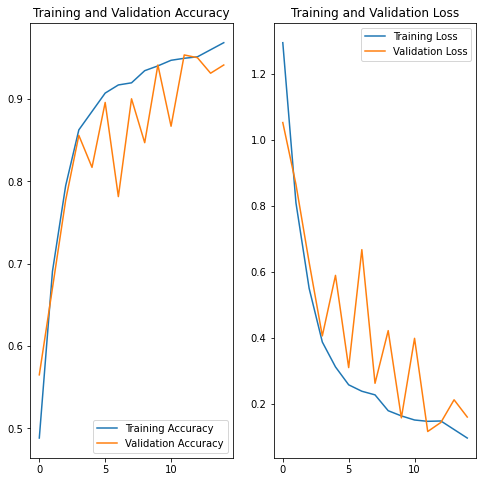

In [33]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(15), acc, label = 'Training Accuracy')
plt.plot(range(15), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label = 'Training Loss')
plt.plot(range(15), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

# ***Model Testing***

In [34]:
def predict_tomato_disease(model, img):
  img_ = tf.keras.preprocessing.image.img_to_array(img)
  img_ = tf.expand_dims(img_, 0)

  predictions = model.predict(img_)
  

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 14ms/step


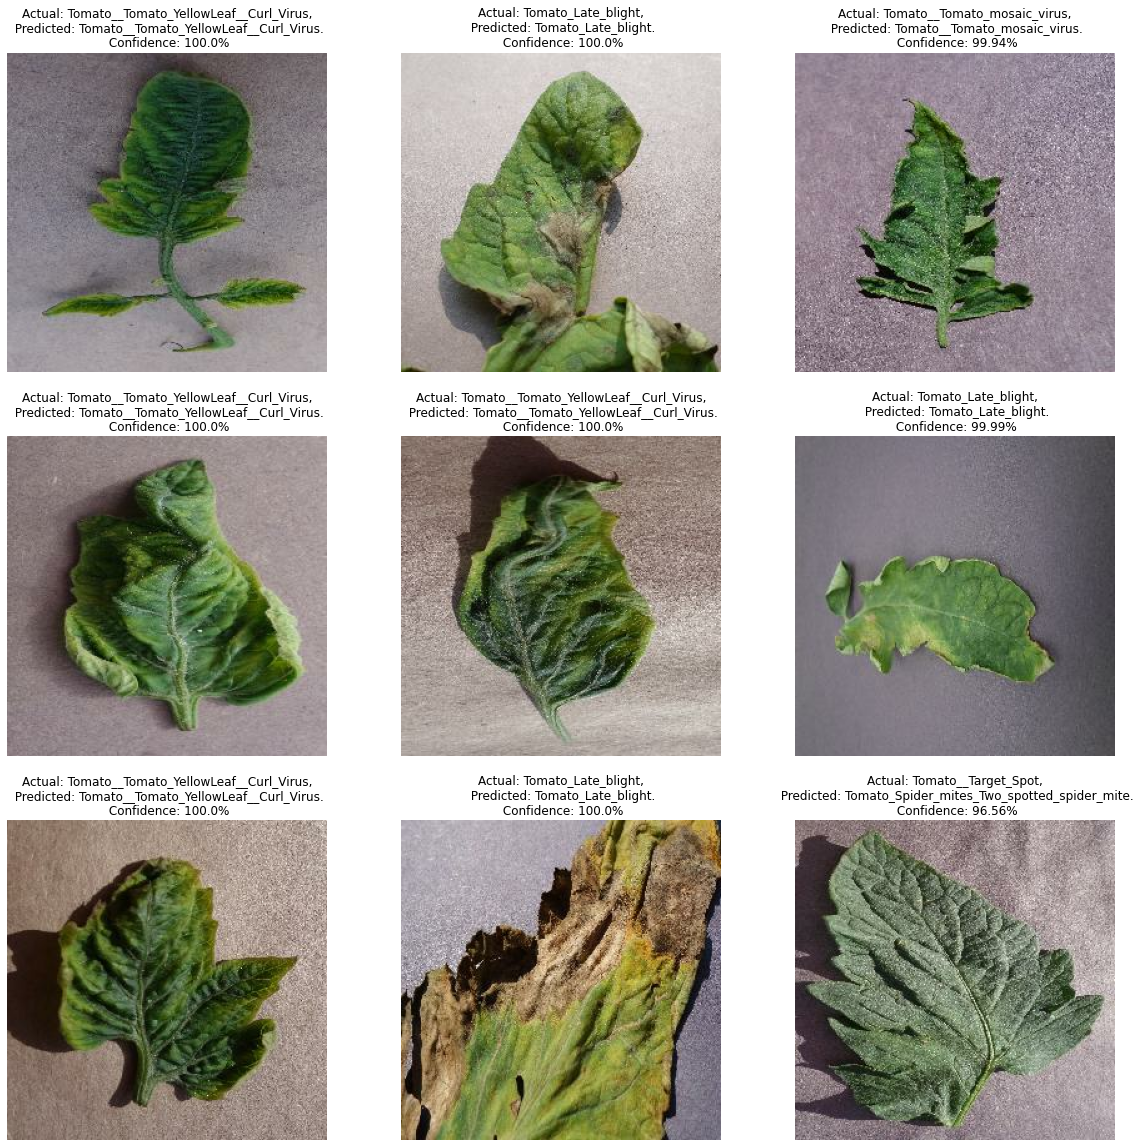

In [39]:
plt.figure(figsize = (20, 20))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_tomato_disease(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")